In [44]:
import jax
import jax.numpy as jnp
import numpy as np
from jax import grad,jit,vmap
#import tensorflow as tf
import matplotlib.pyplot as py
#tf.config.experimental.set_visible_devices([], "GPU")

### Data:

In [3]:
image1= np.ones((28,28)) *0.5

for i in range(2,22): 
  for j in range (2,22): 
    image1[i][j]=1

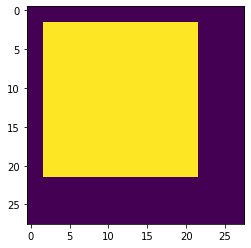

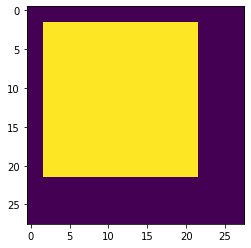

In [4]:
py.imshow(image1)

### Target

In [5]:
target= np.zeros((28,28))
for i in range(2,22): 
  for j in range (2,22): 
    target[i][j]=10

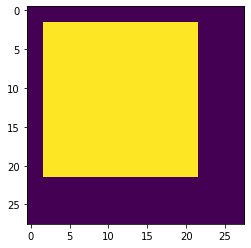

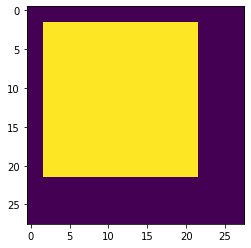

In [6]:
py.imshow(target)

### Reshape

In [7]:
#This needs to be changed to store x,y, I will store the third diemsnion later. 
#each mask contains an x,y coordinate which is what the affine transformation works on.
mask=np.zeros((784,2))
i = 0
for y in range(28):
    for x in range(28): 
      mask[i][0]=y#-14
      mask[i][1]=x#-14
      #mask[i][2]=1
      i+=1

affine_matrix = np.array([[1,0],
                [0,1]])


#The transformation is performed on this mask, and then the sampling occurs on the actual 'feature map'
#I believe this is what happens in Jaderberg et al.? 

In [8]:
modified_mask = np.dot (mask[2],affine_matrix.T)

In [9]:
test=np.zeros((784,2)) 


In [10]:
#feature=image1.reshape(784,2) 
#target=target.reshape(784,2)
#kernel = 10

### Network 
Sampling has to be something like

$ V^C_i = \sum^H_n\sum^W_m U^C_{nm} max (0,1-|x^s_i-m|)max(0,1-|y^s_i-n|)$

which has a very basic form of: 
$V = U \tau F(x,y) $ with $U$ being the feature map

$F(x,y)$ is the sampling, $U$ is the original feature map, and $\tau$ is the affine matrix

### THoughts on implementation: 
From the equation, I feel that what Jaderberg is getting at is basically a algorithm in which a feature map $U_{nm}^C$ is manipulated by affine matrix $\tau$ or $k$....(ie: $V = Uk$) 

The entire algorithm is: $V=Uk(x-m;\phi)(y-n;\phi)$, which basically states, that the transformed image is a function of a feature map, tranformed by affine matrix k, only on the coordinates given by a sampling function parameterized by $\phi$ 

In the code below, 'transformation_network' represents $UK(x-m;\phi)(y-n;\phi)$ 
the sampling network repreesents $V(x-m,y-n;\phi)$ kind of . Like a sampling network that outputs whether or not those coordinates should be manipulated, via parameters $\phi$


In the code below for a given 28x28 image, there will be a matrix that stores all the feature map in the form of a [mn,dim] matrix. This matrix will undergo a affine transformation, with the resulting values being applied to the actual image, if the sampling network deems the actual pixel is worth applying to. 

In [11]:
#Create the coordinates variable. 
coordinates=np.zeros((784,2))
i = 0
for y in range(28):
    for x in range(28): 
      mask[i][0]=y
      mask[i][1]=x
      i+=1


In [109]:
#feature_map will store the actual color value of the image. This will be a [28,28] matrix. 

#affine_matrix is the actual transformation matrix. 
#coordinates is what I was calling a 'mask', and is a array of matrixes [784,2]. 
#I believe this will be constant. 

#The network decides if the pixel will have the affine trasnformation applied. 
def sampling_network(feature_map,parameters,bias):  #parameters will be 1,1  

    #The feature map then enters a sampling network, based on pixel value. 
    layer1=jnp.dot(feature_map,parameters[0].T) + bias[0]  #(32,1) 
    layer1=jax.nn.relu(layer1) 
    layer2=jnp.dot(layer1,parameters[1].T)+bias[1]  #(1,32)
    layer2=jax.nn.sigmoid(layer2) 
    print (layer2)
    return layer2 #This outputs for a single pixel and would have to VMAP to the entire image

#This function takes the affine_matrix and transforms the 784,2 array of vectors. 
# in the code below I have used the sampling network here, but i am debating whether
#or not to just apply this during the transfrmation stage.  
#I realized that I will do this at the level of trasnformation as the sampling_network examines
#the pre-transformation image. 

def transformation_network (affine_matrix,coordinates,feature_map,parameters,bias): 
    #This is basically saying "perform the affine matrix, and apply it whether or not the sampling _networ
    #says to do it. "

    output= jnp.dot(coordinates,affine_matrix.T) * sampling_network(feature_map[coordinates[0].astype(int)][coordinates[1].astype(int)],
                                                                    parameters,bias)
    return output #This should be a 784,2 output. 

#The STN takes pixel by pixel here. This will need to be vectorized in order to generate a complete image and passed to anotehr network 

#This component is done at the end, when all the pixels are iterated through. I assume that this can be eventually vectorized. 

def STN(affine_matrix,coordinates,feature_map,parameters,bias): 
    #First take the image and process it into the sampling_network. 
    #output will contain a 784,2 output, which has been trasnformed and can be applied 
    #to the actual image (feature_map) 
    output=transformation_network(affine_matrix,coordinates,feature_map,parameters,bias)
    return output[0]


vmap_STN = vmap(STN,in_axes=(None,0,None,None,None))

def complete_image(feature_map,transformation):
    
    new_image=np.zeros((28,28))
    feature_map=feature_map.flatten()
    
    for i in range(len(transformation)): 
        x=transformation[i][0].astype(int)
        y=transformation[i][1].astype(int)
        new_image[x][y] = feature_map[i]
        
    return jnp.array(new_image)


def forward(affine_matrix,coordinates,feature_map,parameters,bias): 
    new_coords=jit(vmap_STN)(affine,coordinates,image1,params,biases)
    new_image=complete_image(image1,new_coords)
    return new_image



def MSE_error(feature_map,affine_matrix,coordinates,parameters,bias): 
  pred = forward(affine_matrix,coordinates,feature_map,parameters,bias)
  error = jnp.sum((feature_map-pred))**2/784 #sum over image
  return error

gradient=grad(MSE_error, argnums=(1,3,4),allow_int=True)

def update_params(dparams,dbias,parameters,bias,lr=0.001): 
  for i in range(len(dparams)):
    parameters[i]=parameters[i] - (lr*dparams[i])
    bias[i] = bias[i] - (lr*dbias[i]) 
  return [parameters,bias]

In [110]:
#parameters
params=[]
biases=[]
params.append(np.random.randn(32,1))
params.append(np.random.randn(1,32))
biases.append(np.random.randn(32))
biases.append(np.random.randn(1))

#affine matrix: 
affine=jnp.array([[1.0,0.0],
       [0.0,1.0]])

In [118]:
errors= MSE_error(image1,affine,coordinates,params,biases)


/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [113]:
daffine,dparams,dbias=gradient(image1,affine,coordinates,params,biases)

/usr/local/lib/python3.6/dist-packages/jax/_src/lax/lax.py:6081: UserWarning: Explicitly requested dtype <class 'int'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [119]:
errors

DeviceArray(446.26562, dtype=float32)

### New Training

In [ ]:
for i in range(4): 
  for j in range(784): 
    